# bunching estimation using the real data

take concept from simulation

In [1]:
# load packages

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
import numpy as np
#from scipy.optimize import fsolve
#from scipy import integrate
from sympy import symbols, solve, Eq
import random
from heapq import nlargest
import tools # this imports the file tools.py // must be in the same folder as the current file
import zipfile

np.random.seed(111)


In [2]:
# load data
wd = Path.cwd()
folder = 'stata'
file = 'Outages_{period}.dta'
zip = 'Outages_{period}.zip'
zip = zipfile.ZipFile(wd.parent/folder/zip)
data = pd.read_stata(zip.open(file)) # convert_categoricals = True
#print(data.columns)


data['year'] = data.apply(lambda row: row.date.year, axis=1)

# keep year 2019
#data = data[data.apply(lambda row: row.date.year == 2019, axis=1)]

# keep only unplanned
data = data.loc[data.planned != 'planned',]

# at least 100 custumers affected
data = data.loc[data.noofcustomersaffected >= 100]

data.reset_index(drop = True)

# there is probably some rounding issue in unserveredmuduetooutage
# if it is 0 we replace it with 0.00001
data.loc[data.unservedmuduetooutage.isna() ,'unservedmuduetooutage'] = 0.00001


# keep one firm
#data = data.loc[data.discom == 'tata',]
#data.describe()

density of duration 

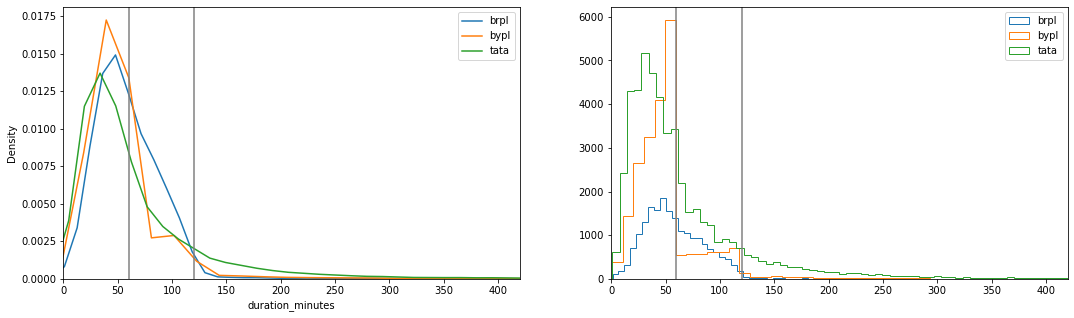

In [4]:
xmax  = 420

fig, axs = plt.subplots(1,2,figsize=(18,5))
for f in data.discom.unique():
    dt = data[data.discom == f]
    sns.kdeplot(dt.duration_minutes, ax = axs[0], label = f)
    axs[1].hist(dt.duration_minutes, histtype = 'step', bins = xmax, label = f)

axs[0].axvline(60, color  = 'grey')
axs[0].axvline(120, color  = 'grey')
axs[0].set_xlim(0,xmax)
axs[0].legend()

axs[1].axvline(60, color  = 'grey')
axs[1].axvline(120, color  = 'grey')
axs[1].set_xlim(0,xmax)
axs[1].legend()

# Bunching Estimation

In [24]:
# bunching at x = 60
bsize = 1
ex_reg = 10
ex_reg_miss = 20
z = 59
z_lower60 = z - bsize*ex_reg

missing60 = z + ex_reg_miss*bsize

bunching = {}
for f in data.discom.unique():
    dt = data[data.discom == f]
    bunch60 = tools.bunching(dt.duration_minutes, bsize = bsize, xmax= 115, xmin= 0, z_upper= z, z_lower= z_lower60, missing = missing60, ex_reg= ex_reg, ex_reg_miss=ex_reg_miss, poly_dgr=6)
    bunching[f] = {'bunch60': bunch60}    
    #display(bunch60.estimation_res())
    print('EX:', bunch60.get_deltaX(), 'mX:', bunch60.get_mX(), 'B:', bunch60.get_B())
    print('total bunching',bunch60.total_bunch())


#print(bunch60.df_count())




EX: -0.3020812629615438 mX: -3.262791873823303 B: -89.24211904142203
total bunching -0.32347439315455523
EX: 8.308873745105332 mX: -14.214969322291198 B: 2648.020789135148
total bunching 12.156995276646507
EX: 2.4314265747849837 mX: 2.418291888789241 B: 1045.804181617038
total bunching 3.220253870118228


In [27]:
# bunching at x = 120
bsize = 1
ex_reg = 10
z = 119
z_lower120 = z - 5 * bsize
missing120 = z + ex_reg * bsize


for f in data.discom.unique():
    dt = data[data.discom == f]
    bunch120 = tools.bunching(dt.duration_minutes, bsize = bsize, xmax= 160, xmin= 90, z_upper= z, z_lower= z_lower120, missing = missing120, ex_reg= ex_reg, ex_reg_miss = ex_reg_miss, poly_dgr=9, include_missing=False)
    bunching[f].update({'bunch120': bunch120})
    #display(bunch120.estimation_res())
    print('deltaX:', bunch120.get_deltaX())
    print('total bunching',bunch120.total_bunch())

#print(bunch120.df_count())


deltaX: 1.0750935934714858
total bunching 0.20402852095843785
deltaX: 3.1784042177717065
total bunching 21.222889594842897
deltaX: 2.6161394640675932
total bunching 0.985919418343619


plot of counterfactual and actual data

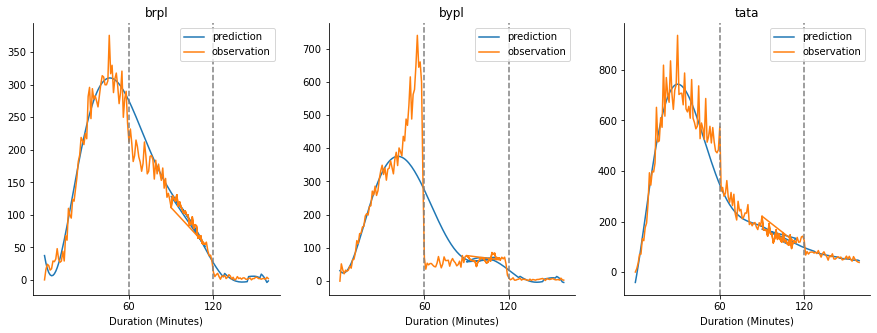

In [43]:

fig, ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    f = data.discom.unique()[i]
    # concat the two predictions
    pred60 = bunching[f]['bunch60'].prediction()
    pred120 = bunching[f]['bunch120'].prediction()
    pred = pd.concat([pred60,pred120], ignore_index=True)

    ax[i].plot(pred.duration, pred.y_pred, label = 'prediction')
    ax[i].plot(pred.duration, pred.nobs, label = 'observation')
    ax[i].axvline(60, color= 'grey', linestyle = 'dashed')
    ax[i].axvline(120, color= 'grey', linestyle = 'dashed')
    ax[i].set_xticks(ticks = [60, 120])
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlabel('Duration (Minutes)')
    ax[i].set_title(f)
    ax[i].legend()

Visualize $\Delta x$

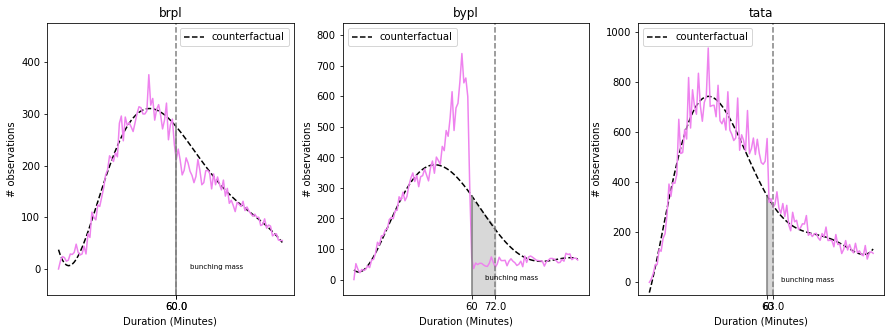

In [48]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
min = -50
for i in range(3):
    f = data.discom.unique()[i]
    bunch = bunching[f]['bunch60']
    pred60 = bunching[f]['bunch60'].prediction()
    b = np.round(60 + bunch.total_bunch())
    ax[i].plot(pred60.duration[pred60.duration >= 0], pred60.y_pred[pred60.duration >= 0], color = 'black', linestyle='dashed', label = 'counterfactual')
    ax[i].plot(pred60.duration, pred60.nobs, color = 'violet')
    ax[i].plot([60,60], [min,pred60.loc[pred60.duration == 60, 'y_pred'].reset_index(drop=True)[0]], color = 'grey')
    ax[i].axvline(b,color='grey', linestyle = 'dashed')
    ax[i].set_xlabel('Duration (Minutes)')
    ax[i].set_ylabel('# observations')
    ax[i].set_xticks([60 , b])
    ax[i].set_xticklabels(labels = [60,b])
    ax[i].set_ylim(min,pred60.nobs.max()+ 100)
    ax[i].fill_between(np.linspace(60,b,np.sum((pred60.duration > 60) & (pred60.duration < b))),pred60.y_pred[(pred60.duration > 60) & (pred60.duration < b)], np.repeat(min,np.sum((pred60.duration > 60) & (pred60.duration < b))), alpha = .3, color = 'grey')
    ax[i].annotate('bunching mass', xy = (67,min + 50), size = 7)
    ax[i].legend()
    ax[i].set_title(f)

#fig.savefig('xdensity.png',dpi=120, format='png')

## get counterfactual duration at outage level

!! this is maybe not optimal. Right now, I am assuming a poisson distribution in the bins of the missing mass. \


In [101]:
for f in data.discom.unique():
    bunch60 = bunching[f]['bunch60']
    bunch120 = bunching[f]['bunch120']
    # concat the two predictions
    pred60 = bunch60.prediction()
    pred120 = bunch120.prediction()
    pred60 = pred60[pred60.duration <= 100]
    pred120 = pred120[pred120.duration > 100]
    cf = pd.concat([pred60,pred120], ignore_index=True)
    # first need to get the counterfactuals for the bins    
    cf = cf.loc[:,['bin', 'nobs', 'duration', 'b', 'm','y_pred']]
    cf['difference'] = cf.nobs - cf.y_pred
    # make sure that at least one bin is in missing
    upper60 = 60 + abs(bunch60.total_bunch()) + bsize 
    upper120 = 120 + abs(bunch120.total_bunch()) + bsize 
    # create dummies
    cf['b60'] = cf.apply(lambda row: 1 if (row.b ==1) & (row.duration <= missing60) else 0, axis = 1)
    cf['missing60'] = cf.apply(lambda row: 1 if (row.duration > 60) & (row.duration <= upper60) else 0, axis = 1)
    cf['b120'] = cf.apply(lambda row: 1 if (row.b ==1) & (row.duration >= z_lower120) else 0, axis = 1)
    cf['missing120'] = cf.apply(lambda row: 1 if (row.duration > 120) & (row.duration <= upper120) else 0, axis = 1)

    # calculate missing
    sum60 = cf.loc[(cf.duration > 60) & (cf.duration <= upper60) & (cf.y_pred >= 0),'y_pred'].sum()
    sum120 = cf.loc[(cf.duration > 120) & (cf.duration <= upper120) & (cf.y_pred >= 0),'y_pred'].sum()

    # calculate probability of being in bin, avoiding negative probabilities
    cf['prob'] = 0
    cf.loc[(cf.duration > 60) & (cf.duration <= upper60) & (cf.y_pred >= 0), 'prob'] = cf.y_pred / sum60
    cf.loc[(cf.duration > 120) & (cf.duration <= upper120) & (cf.y_pred >= 0), 'prob'] = cf.y_pred / sum120

    print(cf.prob.sum() == 2)
    #print(cf[(cf.b60 == 1) | (cf.b120 == 1) | (cf.missing120 == 1) | (cf.missing60 == 1)])

    # save in dictionary
    bunching[f].update({'counterfactual_bins':cf})

True
True
True


In [103]:

## difference in b60 need to be distributed to missing mass
## can we improve this? It is okay but not optimal

# new column
data['duration_cf'] = data.duration_minutes

for f in data.discom.unique():
    # subset dataframe but keep index
    dt =  data[data.discom == f]
    # get counterfactual bins
    cf = bunching[f]['counterfactual_bins']

    dict = {'60': cf.loc[(cf.b60 ==1) & (cf.difference >0),].index, '120': cf.loc[(cf.b120 ==1) & (cf.difference >0),].index}
    dict_m = {'60': cf.missing60, '120':cf.missing120}

    for d in ['60','120']:
        ind = dict[d]
        m = dict_m[d]
        for b in ind:
            # select bin
            bin = cf.bin[b]   
            # get 'extra' observations
            diff = np.round(cf.difference[b]).astype(int)
            #print(bin, diff)
            # extract the data in bin and select n = diff random values
            new_data = dt.loc[(dt.duration_cf >= bin[0]) & (dt.duration_cf <= bin[1])].sample(n = diff, axis = 0)
            # now randomly choose a bin in the missing mass, weighted by prob of observations being in that bin bin
            mis = cf.loc[m == 1,].sample(n=1, axis =0, weights = cf.prob).bin.reset_index(drop=True)[0]
            # create n=diff random values in bin
            new = np.random.poisson((mis[1] +  mis[0])/2, size = diff) # here I am assuming a poisson distribution in the bins
            # replace values in new_data
            data.loc[new_data.index.tolist(),'duration_cf'] = new

#data.describe()

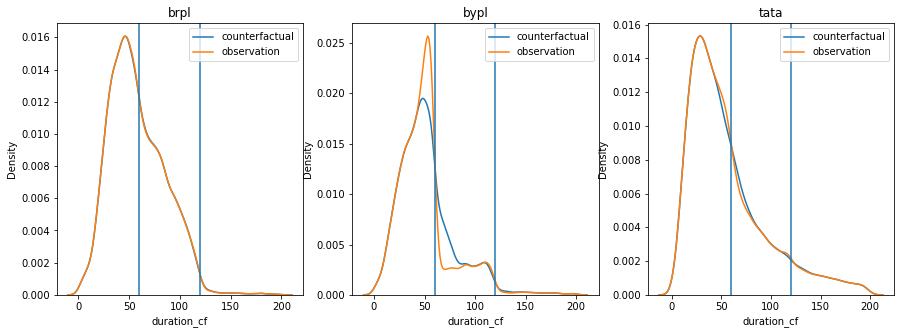

In [105]:
# should look similar to counterfactual density from bunching estimation
fig, ax = plt.subplots(1,3,figsize=(15,5))
for i in range(3):
    f = data.discom.unique()[i]
    dt = data[data.discom == f]
    sns.kdeplot(dt.duration_cf[dt.duration_cf < 200], label = 'counterfactual', ax = ax[i])
    sns.kdeplot(dt.duration_minutes[dt.duration_minutes < 200], label='observation', ax = ax[i])
    ax[i].axvline(60)
    ax[i].axvline(120)
    ax[i].legend()
    ax[i].set_title(f)
#plt.xlim(55,65)
#plt.ylim(0.000,0.004)


In [106]:
# export 
data.to_csv(wd.parent/'data'/'data_transformed'/'outage_bunch.csv', index=False)